## In this notebook, we will analyze Python 3 support for actively developed production ready packages in PyPI.

Actively developed : Must have released a new version in the last year

Production ready : The Trove Classifier for Development Status should be set to Production/Stable or Mature

In [28]:
import arrow
from django.db.models import Q

from package_info.models import PackageInfo

all_packages = PackageInfo.objects.all()
print("Found {0} packages in PyPI".format(all_packages.count()))
# First, get rid of packages that don't include trove classifiers 
# and packages which do not list any release.
legit_packages = PackageInfo.objects.exclude(has_classifiers = False).exclude(
    last_release_date = None)
# Select for active packages (at least one release in the last year)
one_year_ago = arrow.now().replace(years = -1).datetime.date()
active_packages = legit_packages.exclude(last_release_date__lt = one_year_ago) 
print("Found {0} active packages.".format(active_packages.count()))
# select for production ready packages
active_production_ready_packages = active_packages.filter(
    Q(development_status = "Development Status :: 5 - Production/Stable") | 
    Q(development_status = "Development Status :: 6 - Mature"))
print("Found {0} active production ready packages".format(
    active_production_ready_packages.count()))

Found 94435 packages in PyPI
Found 25723 active packages.
Found 6051 active production ready packages


### Let's find out python 3 coverage of these active production ready packages

Python 3 coverage of active production ready packages is 71.64105106593951


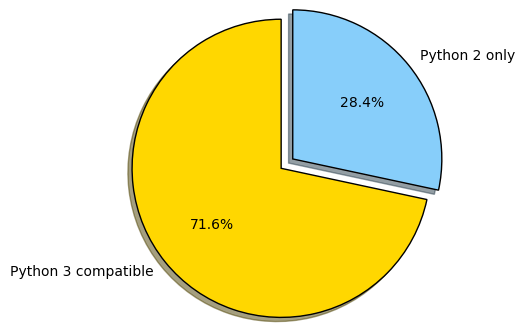

In [29]:
from plots import draw_pie_chart
py3_active_production_ready_packages = active_production_ready_packages.filter(
    python3_compatible = True)
py3_coverage = (py3_active_production_ready_packages.count()
                /float(active_production_ready_packages.count())*100)
print("Python 3 coverage of active production ready packages is {0}".format(
    py3_coverage))
draw_pie_chart([py3_coverage, 100 - py3_coverage], 
               [ "gold", "lightskyblue" ], 
               ["Python 3 compatible", "Python 2 only"],
               [0.1, 0])

### How difficult is it to port the Python2-only packages to Python3?  

We will decide this based on the overall size of the source distribution. 
- If the source has size less than 10 kB, we will assume that it is easy to port it.
- If the source has size between 10 kB and 100 kB, we will assume intemediate difficulty in porting.
- If the size exceeds 100 kB, then the package is large enough to be considered a "blocker package". These packages can potentially block adoption of Python 3 in some projects.

25.090689238210402 percent of Python 2 only packages are very difficult to port


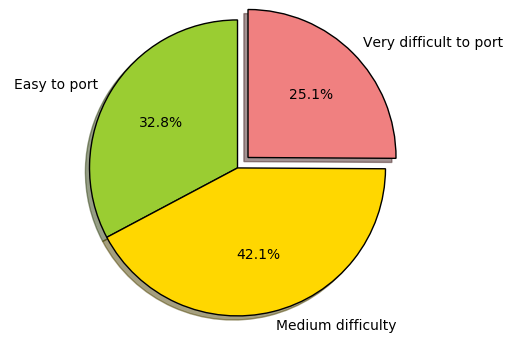

In [27]:
py2_active_production_ready_packages = active_production_ready_packages.exclude(
    python3_compatible = True).exclude(last_release_size_source = None)
lt_10kb = py2_active_production_ready_packages.filter(
    last_release_size_source__lt = 10000)
gt_10kb_lt_100kb = py2_active_production_ready_packages.filter(
    last_release_size_source__gt = 10000).filter(
    last_release_size_source__lt = 100000)
gt_100kb = py2_active_production_ready_packages.filter(
    last_release_size_source__gt = 100000)
lt_10kb_percentage = lt_10kb.count()/float(
    py2_active_production_ready_packages.count())*100
gt_10kb_lt_100kb_percentage = gt_10kb_lt_100kb.count()/float(
    py2_active_production_ready_packages.count())*100
gt_100kb_percentage = gt_100kb.count()/float(
    py2_active_production_ready_packages.count())*100
print("{0} percent of Python 2 only packages are very difficult to port".format(
    gt_100kb_percentage ))
draw_pie_chart([lt_10kb_percentage, gt_10kb_lt_100kb_percentage, gt_100kb_percentage], 
               ["yellowgreen", "gold", "lightcoral" ], 
               ["Easy to port", "Medium difficulty", "Very difficult to port"],
               [0, 0, 0.1])